In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import itertools
import sympy as sp

import gamelab.finitegames as nfg
import symplecticFTRL
import choice
import aspera.utils

In [3]:
primal_letter = 'x'
dual_letter = 'y'
quot_letter = 'z'

## Utils

In [4]:
# switch between coords and points
#def coords_points(L):

	#https://stackoverflow.com/questions/2921847/what-does-the-star-operator-mean-in-a-function-call
#	def make(*values):
#		return values

#	return make(*zip(*L))

In [5]:
flatten = nfg.Utils.flatten
coords_points = aspera.utils.coords_points

# Symplectic FTRL on mixed extension of $[2 \times 2]$ normal form games

In [6]:
skeleton = [2, 2]

In [7]:
BARE = nfg.NFG_bare(skeleton, "numeric", primal_letter)

Dummy payoffs for [2, 2] game
Player 0 - Pure = (0, 0) = [array([1., 0.]), array([1., 0.])] - Payoff = 1
Player 0 - Pure = (0, 1) = [array([1., 0.]), array([0., 1.])] - Payoff = 2
Player 0 - Pure = (1, 0) = [array([0., 1.]), array([1., 0.])] - Payoff = 3
Player 0 - Pure = (1, 1) = [array([0., 1.]), array([0., 1.])] - Payoff = 4
Player 1 - Pure = (0, 0) = [array([1., 0.]), array([1., 0.])] - Payoff = 5
Player 1 - Pure = (0, 1) = [array([1., 0.]), array([0., 1.])] - Payoff = 6
Player 1 - Pure = (1, 0) = [array([0., 1.]), array([1., 0.])] - Payoff = 7
Player 1 - Pure = (1, 1) = [array([0., 1.]), array([0., 1.])] - Payoff = 8


In [8]:
help(nfg.NFG)

Help on class NFG in module gamelab.finitegames:

class NFG(NFG_bare)
 |  NFG(skeleton, strat_format, primal_letter, dual_letter, name, payoff_tensors, **kwargs)
 |
 |  docstring for ClassName
 |
 |  Method resolution order:
 |      NFG
 |      NFG_bare
 |      Skeleton
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, skeleton, strat_format, primal_letter, dual_letter, name, payoff_tensors, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  make_clean_payfield(self)
 |
 |  make_pay_devs(self)
 |
 |  make_pay_dict(self)
 |
 |  make_response_graph(self, fig, ax, plot_all=True)
 |
 |  plot_support_222(self, strat)
 |
 |  present_payoff(self)
 |
 |  ----------------------------------------------------------------------
 |  Methods inherited from NFG_bare:
 |
 |  find_support(self, x)
 |      faster, breaks cycle as just as zero is found
 |
 |  find_support_brute(self, x)
 |      slower, computes everything
 |
 |  make_packed(se

In [9]:
BARE.strat

[Matrix([
 [x0_0],
 [x0_1]]),
 Matrix([
 [x1_0],
 [x1_1]])]

In [10]:
BARE.primal_vars

[x0_0, x0_1, x1_0, x1_1]

In [11]:
BARE.make_vars('y', skeleton)

[y0_0, y0_1, y1_0, y1_1]

In [12]:
BARE.strat_play

(x0, x1)

## Games

In [13]:
# Matching pennies
payoff = [3, -3, -3, 3, -3, 3, 3, -3]
MP = nfg.NFG(skeleton = skeleton , strat_format = 'numeric', primal_letter = primal_letter, dual_letter = dual_letter, name = 'Matching Pennies', payoff_tensors =  nfg.Utils.u_flat_to_tensor(payoff, skeleton))

Dummy payoffs for [2, 2] game
Player 0 - Pure = (0, 0) = [array([1., 0.]), array([1., 0.])] - Payoff = 1
Player 0 - Pure = (0, 1) = [array([1., 0.]), array([0., 1.])] - Payoff = 2
Player 0 - Pure = (1, 0) = [array([0., 1.]), array([1., 0.])] - Payoff = 3
Player 0 - Pure = (1, 1) = [array([0., 1.]), array([0., 1.])] - Payoff = 4
Player 1 - Pure = (0, 0) = [array([1., 0.]), array([1., 0.])] - Payoff = 5
Player 1 - Pure = (0, 1) = [array([1., 0.]), array([0., 1.])] - Payoff = 6
Player 1 - Pure = (1, 0) = [array([0., 1.]), array([1., 0.])] - Payoff = 7
Player 1 - Pure = (1, 1) = [array([0., 1.]), array([0., 1.])] - Payoff = 8
Player 0 - Pure = (0, 0) = [array([1., 0.]), array([1., 0.])] - Payoff = 3
Player 0 - Pure = (0, 1) = [array([1., 0.]), array([0., 1.])] - Payoff = -3
Player 0 - Pure = (1, 0) = [array([0., 1.]), array([1., 0.])] - Payoff = -3
Player 0 - Pure = (1, 1) = [array([0., 1.]), array([0., 1.])] - Payoff = 3
Player 1 - Pure = (0, 0) = [array([1., 0.]), array([1., 0.])] - Payo

In [14]:
MP.payfield

[[3*x1_0 - 3*x1_1, -3*x1_0 + 3*x1_1], [-3*x0_0 + 3*x0_1, 3*x0_0 - 3*x0_1]]

In [15]:
MP.quotpayfield

[array([0, -6*x1_0 + 6*x1_1], dtype=object),
 array([0, 6*x0_0 - 6*x0_1], dtype=object)]

In [16]:
MP.map_payfield.present()


V: X0 x X1(4) --> TY0 x TY1(4) 
 (x0_0, x0_1, x1_0, x1_1) --> (y'0_0, y'0_1, y'1_0, y'1_1) = [3*x1_0 - 3*x1_1, -3*x1_0 + 3*x1_1, -3*x0_0 + 3*x0_1, 3*x0_0 - 3*x0_1]


In [17]:
MP.map_quotpayfield.present()


v: X0 x X1(4) --> TZ0 x TZ1(4) 
 (x0_0, x0_1, x1_0, x1_1) --> (z'0_0, z'0_1, z'1_0, z'1_1) = [0, -6*x1_0 + 6*x1_1, 0, 6*x0_0 - 6*x0_1]


In [18]:
MP.map_eff_quotpayfield.present()


v: X0 x X1(2) --> TZ0 x TZ1(2) 
 (x0_1, x1_1) --> (z'0_1, z'1_1) = [12*x1_1 - 6, 6 - 12*x0_1]


In [19]:


# generalized harmonic
payoff = [-1, -4, -3, -1, 1, 2, 2, -2] 
GH = nfg.NFG(skeleton = skeleton , strat_format = 'numeric', primal_letter = primal_letter, dual_letter = dual_letter, name = 'Generalized Harmonic', payoff_tensors =  nfg.Utils.u_flat_to_tensor(payoff, skeleton))

# prisoner's dilemma
payoff = [2, 0, 3, 1, 2, 3, 0, 1]
PD = nfg.NFG(skeleton = skeleton , strat_format = 'numeric', primal_letter = primal_letter, dual_letter = dual_letter, name = 'Prisoners Dilemma', payoff_tensors =  nfg.Utils.u_flat_to_tensor(payoff, skeleton))

# split or steal
payoff = [5, 0, 10, 0, 5, 10, 0, 0]
SS = nfg.NFG(skeleton = skeleton , strat_format = 'numeric', primal_letter = primal_letter, dual_letter = dual_letter, name = 'Split or Steal', payoff_tensors =  nfg.Utils.u_flat_to_tensor(payoff, skeleton))

# battle of sexes
payoff = [3, 0, 0, 2, 2, 0, 0, 3]
BS = nfg.NFG(skeleton = skeleton , strat_format = 'numeric', primal_letter = primal_letter, dual_letter = dual_letter, name = 'Battle of the Sexes', payoff_tensors =  nfg.Utils.u_flat_to_tensor(payoff, skeleton))

# chicken
payoff = [-5, 2, 1, 0, -5, 1, 2, 0]
CH = nfg.NFG(skeleton = skeleton , strat_format = 'numeric', primal_letter = primal_letter, dual_letter = dual_letter, name = 'Chicken', payoff_tensors =  nfg.Utils.u_flat_to_tensor(payoff, skeleton))

# coordination
payoff = [5, 1, 1, 4, 5, 1, 1, 4]
CO = nfg.NFG(skeleton = skeleton , strat_format = 'numeric', primal_letter = primal_letter, dual_letter = dual_letter, name = 'Coordination', payoff_tensors =  nfg.Utils.u_flat_to_tensor(payoff, skeleton))

# anti-coordination
payoff = [1, 5, 4, 1, 1, 4, 5, 1]
ACO = nfg.NFG(skeleton = skeleton , strat_format = 'numeric', primal_letter = primal_letter, dual_letter = dual_letter, name = 'Anti-Coordination', payoff_tensors =  nfg.Utils.u_flat_to_tensor(payoff, skeleton))

# cyclic
payoff = [5, 1, 1, 4, -5, 1, 1, -4]
CY = nfg.NFG(skeleton = skeleton , strat_format = 'numeric', primal_letter = primal_letter, dual_letter = dual_letter, name = 'Cyclic', payoff_tensors =  nfg.Utils.u_flat_to_tensor(payoff, skeleton))

Dummy payoffs for [2, 2] game
Player 0 - Pure = (0, 0) = [array([1., 0.]), array([1., 0.])] - Payoff = 1
Player 0 - Pure = (0, 1) = [array([1., 0.]), array([0., 1.])] - Payoff = 2
Player 0 - Pure = (1, 0) = [array([0., 1.]), array([1., 0.])] - Payoff = 3
Player 0 - Pure = (1, 1) = [array([0., 1.]), array([0., 1.])] - Payoff = 4
Player 1 - Pure = (0, 0) = [array([1., 0.]), array([1., 0.])] - Payoff = 5
Player 1 - Pure = (0, 1) = [array([1., 0.]), array([0., 1.])] - Payoff = 6
Player 1 - Pure = (1, 0) = [array([0., 1.]), array([1., 0.])] - Payoff = 7
Player 1 - Pure = (1, 1) = [array([0., 1.]), array([0., 1.])] - Payoff = 8
Player 0 - Pure = (0, 0) = [array([1., 0.]), array([1., 0.])] - Payoff = -1
Player 0 - Pure = (0, 1) = [array([1., 0.]), array([0., 1.])] - Payoff = -4
Player 0 - Pure = (1, 0) = [array([0., 1.]), array([1., 0.])] - Payoff = -3
Player 0 - Pure = (1, 1) = [array([0., 1.]), array([0., 1.])] - Payoff = -1
Player 1 - Pure = (0, 0) = [array([1., 0.]), array([1., 0.])] - Pa

In [89]:
# Generalized harmonic with NE on boundary
payoff = [-1, 1, 1, -1, 1, -1, -1, -1]
GHB = nfg.NFG(skeleton = skeleton , strat_format = 'numeric', primal_letter = primal_letter, dual_letter = dual_letter, name = 'Boundary Generalized Harmonic', payoff_tensors =  nfg.Utils.u_flat_to_tensor(payoff, skeleton))

Dummy payoffs for [2, 2] game
Player 0 - Pure = (0, 0) = [array([1., 0.]), array([1., 0.])] - Payoff = 1
Player 0 - Pure = (0, 1) = [array([1., 0.]), array([0., 1.])] - Payoff = 2
Player 0 - Pure = (1, 0) = [array([0., 1.]), array([1., 0.])] - Payoff = 3
Player 0 - Pure = (1, 1) = [array([0., 1.]), array([0., 1.])] - Payoff = 4
Player 1 - Pure = (0, 0) = [array([1., 0.]), array([1., 0.])] - Payoff = 5
Player 1 - Pure = (0, 1) = [array([1., 0.]), array([0., 1.])] - Payoff = 6
Player 1 - Pure = (1, 0) = [array([0., 1.]), array([1., 0.])] - Payoff = 7
Player 1 - Pure = (1, 1) = [array([0., 1.]), array([0., 1.])] - Payoff = 8
Player 0 - Pure = (0, 0) = [array([1., 0.]), array([1., 0.])] - Payoff = -1
Player 0 - Pure = (0, 1) = [array([1., 0.]), array([0., 1.])] - Payoff = 1
Player 0 - Pure = (1, 0) = [array([0., 1.]), array([1., 0.])] - Payoff = 1
Player 0 - Pure = (1, 1) = [array([0., 1.]), array([0., 1.])] - Payoff = -1
Player 1 - Pure = (0, 0) = [array([1., 0.]), array([1., 0.])] - Payo

In [91]:
#GAMES = [MP, GH, PD, SS, BS, CH, CO, ACO, CY]
#GAMES = [MP, GH, PD, CY]

GAMES = [GHB]

## Vars

In [21]:
primal_vars = BARE.primal_vars
primal_vars

[x0_0, x0_1, x1_0, x1_1]

In [22]:
dual_vars = BARE.make_vars(dual_letter, skeleton)
dual_vars

[y0_0, y0_1, y1_0, y1_1]

In [23]:
quot_vars = BARE.make_vars(quot_letter, skeleton)
quot_vars

[z0_0, z0_1, z1_0, z1_1]

In [24]:
BARE.make_vars_play(dual_letter, skeleton)

(y0, y1)

In [25]:
BARE.make_packed(dual_letter, skeleton)

[(y0_0, y0_1), (y1_0, y1_1)]

In [26]:
# LOGIT CHOICE
#sym_choice = [
#    sp.exp(dual_vars[0]) / ( sp.exp(dual_vars[0]) +  sp.exp(dual_vars[1])),
#    sp.exp(dual_vars[1]) / ( sp.exp(dual_vars[0]) +  sp.exp(dual_vars[1])),
#    sp.exp(dual_vars[2]) / ( sp.exp(dual_vars[2]) +  sp.exp(dual_vars[3])),
#    sp.exp(dual_vars[3]) / ( sp.exp(dual_vars[2]) +  sp.exp(dual_vars[3])),
#]

In [27]:
logit = choice.MultiLogit(primal_letter, dual_letter, skeleton)
logit.Q.ex

Dummy payoffs for [2, 2] game
Player 0 - Pure = (0, 0) = [array([1., 0.]), array([1., 0.])] - Payoff = 1
Player 0 - Pure = (0, 1) = [array([1., 0.]), array([0., 1.])] - Payoff = 2
Player 0 - Pure = (1, 0) = [array([0., 1.]), array([1., 0.])] - Payoff = 3
Player 0 - Pure = (1, 1) = [array([0., 1.]), array([0., 1.])] - Payoff = 4
Player 1 - Pure = (0, 0) = [array([1., 0.]), array([1., 0.])] - Payoff = 5
Player 1 - Pure = (0, 1) = [array([1., 0.]), array([0., 1.])] - Payoff = 6
Player 1 - Pure = (1, 0) = [array([0., 1.]), array([1., 0.])] - Payoff = 7
Player 1 - Pure = (1, 1) = [array([0., 1.]), array([0., 1.])] - Payoff = 8


Matrix([
[exp(y0_0)/(exp(y0_0) + exp(y0_1))],
[exp(y0_1)/(exp(y0_0) + exp(y0_1))],
[exp(y1_0)/(exp(y1_0) + exp(y1_1))],
[exp(y1_1)/(exp(y1_0) + exp(y1_1))]])

# Z quotient

In [28]:
quotlogit = choice.QuotientMultiLogit(primal_letter, dual_letter, skeleton, quot_letter)
quotlogit.Q.ex

Dummy payoffs for [2, 2] game
Player 0 - Pure = (0, 0) = [array([1., 0.]), array([1., 0.])] - Payoff = 1
Player 0 - Pure = (0, 1) = [array([1., 0.]), array([0., 1.])] - Payoff = 2
Player 0 - Pure = (1, 0) = [array([0., 1.]), array([1., 0.])] - Payoff = 3
Player 0 - Pure = (1, 1) = [array([0., 1.]), array([0., 1.])] - Payoff = 4
Player 1 - Pure = (0, 0) = [array([1., 0.]), array([1., 0.])] - Payoff = 5
Player 1 - Pure = (0, 1) = [array([1., 0.]), array([0., 1.])] - Payoff = 6
Player 1 - Pure = (1, 0) = [array([0., 1.]), array([1., 0.])] - Payoff = 7
Player 1 - Pure = (1, 1) = [array([0., 1.]), array([0., 1.])] - Payoff = 8


Matrix([
[        1/(exp(z0_1) + 1)],
[exp(z0_1)/(exp(z0_1) + 1)],
[        1/(exp(z1_1) + 1)],
[exp(z1_1)/(exp(z1_1) + 1)]])

In [29]:
quotlogit.eff_Q.ex

Matrix([
[exp(z0_1)/(exp(z0_1) + 1)],
[exp(z1_1)/(exp(z1_1) + 1)]])

### Access primal and dual spaces either by primal space and dual space of MultiLogit instance, or domain and codomain of Map instance

In [30]:
logit.primal_space.present()

X0 x X1 4 (x0_0, x0_1, x1_0, x1_1)


In [31]:
logit.Q.codomain.present()

X0 x X1 4 (x0_0, x0_1, x1_0, x1_1)


In [32]:
logit.dual_space.present()

Y0 x Y1 4 (y0_0, y0_1, y1_0, y1_1)


In [33]:
logit.Q.domain.present()

Y0 x Y1 4 (y0_0, y0_1, y1_0, y1_1)


## Symplectic FTRL

In [92]:
SFTRL_GAMES = [ symplecticFTRL.SFTRL(game.map_payfield, logit.Q, primal_vars, dual_vars, game.name) for game in GAMES ]

In [93]:
SFTRL_GAMES[0].choice( 1, 2, 3, 4 )

[0.2689414213699951,
 0.7310585786300049,
 0.2689414213699951,
 0.7310585786300048]

In [94]:
SFTRL_GAMES[0].payfield(1, 2, 3, 4)

[1, -1, -1, -3]

In [95]:
SFTRL_GAMES[0].dVQ_VQ(1, 2, 3, 4)

[0.02979287579116996,
 -0.02979287579116996,
 -0.7268619813835873,
 0.3634309906917935]

## Z FTRL

In [96]:
ZSFTRL_GAMES = [ symplecticFTRL.ZSFTRL(game.map_quotpayfield, quotlogit.Q, primal_vars, quot_vars, game.name) for game in GAMES ]

In [97]:
test = ZSFTRL_GAMES[0]

In [98]:
test.map_VQ.present()


v(q_0 x q_1): Z0 x Z1(4) --> TZ0 x TZ1(4) 
 (z0_0, z0_1, z1_0, z1_1) --> (z'0_0, z'0_1, z'1_0, z'1_1) = [0, -2*tanh(z1_1/2), 0, -2/(exp(z0_1) + 1)]


In [99]:
test.sym_JQ

Matrix([
[0,                              -exp(z0_1)/(exp(z0_1) + 1)**2, 0,                                                          0],
[0, exp(z0_1)/(exp(z0_1) + 1) - exp(2*z0_1)/(exp(z0_1) + 1)**2, 0,                                                          0],
[0,                                                          0, 0,                              -exp(z1_1)/(exp(z1_1) + 1)**2],
[0,                                                          0, 0, exp(z1_1)/(exp(z1_1) + 1) - exp(2*z1_1)/(exp(z1_1) + 1)**2]])

In [100]:
ZSFTRL_GAMES[0].VQ(1, 2, 3, 4)

[0, -1.9280551601516338, 0, -0.2384058440442351]

## Effective Z SFTRL

In [101]:
MP.map_eff_quotpayfield.present()


v: X0 x X1(2) --> TZ0 x TZ1(2) 
 (x0_1, x1_1) --> (z'0_1, z'1_1) = [12*x1_1 - 6, 6 - 12*x0_1]


In [102]:
quotlogit.eff_Q.present()


q_0 x q_1: Z0 x Z1(2) --> X0 x X1(2) 
 (z0_1, z1_1) --> (x0_1, x1_1) = [exp(z0_1)/(exp(z0_1) + 1), exp(z1_1)/(exp(z1_1) + 1)]


In [103]:
quotlogit.eff_Q.domain.vars

(z0_1, z1_1)

In [104]:
quotlogit.eff_Q.codomain.vars

(x0_1, x1_1)

In [105]:
eff_ZSFTRL_GAMES = [ symplecticFTRL.ZSFTRL(game.map_eff_quotpayfield, quotlogit.eff_Q, quotlogit.eff_Q.codomain.vars, quotlogit.eff_Q.domain.vars, game.name) for game in GAMES ]

Init geometric version
pull done...
diff done...
product done...
Inverse done, Symbolic computations over


In [106]:
test = eff_ZSFTRL_GAMES[0]

In [107]:
test

In [108]:
test.map_VQ.present()


v(q_0 x q_1): Z0 x Z1(2) --> TZ0 x TZ1(2) 
 (z0_1, z1_1) --> (z'0_1, z'1_1) = [-2*tanh(z1_1/2), -2/(exp(z0_1) + 1)]


In [109]:
test.sym_JQ

Matrix([
[exp(z0_1)/(exp(z0_1) + 1) - exp(2*z0_1)/(exp(z0_1) + 1)**2,                                                          0],
[                                                         0, exp(z1_1)/(exp(z1_1) + 1) - exp(2*z1_1)/(exp(z1_1) + 1)**2]])

In [110]:
test.sym_JQ.inv()

Matrix([
[(exp(3*z0_1) + 3*exp(2*z0_1) + 3*exp(z0_1) + 1)/(exp(2*z0_1) + exp(z0_1)),                                                                         0],
[                                                                        0, (exp(3*z1_1) + 3*exp(2*z1_1) + 3*exp(z1_1) + 1)/(exp(2*z1_1) + exp(z1_1))]])

In [111]:
test.sym_symplectic_vfield

Matrix([
[                                                                                            -6/(exp(z0_1)*cosh(z1_1) + exp(z0_1) + cosh(z1_1) + 1)],
[6*(exp(3*z1_1) + 3*exp(2*z1_1) + 3*exp(z1_1) + 1)*exp(z0_1 - z1_1)*tanh(z1_1/2)/((exp(z1_1) + 1)*(cosh(z1_1) + 1)*(exp(2*z0_1) + 2*exp(z0_1) + 1))]])

In [112]:
test.quot_vars

(z0_1, z1_1)

In [113]:
eff_ZSFTRL_GAMES[0].symplectic_vfield(2,3)

[-0.06462227816548388, 1.1404171256627649]

In [114]:
eff_ZSFTRL_GAMES[0].dVQ_VQ(2,3)

[-0.09314368747169614, 0.707271639175136]

In [115]:
ZSFTRL_GAMES[0].dVQ_VQ(0, 2, 0, 3)

[0, -0.09314368747169614, 0, 0.707271639175136]

# Riemannian Symplectic FTRL in space of payoff differences

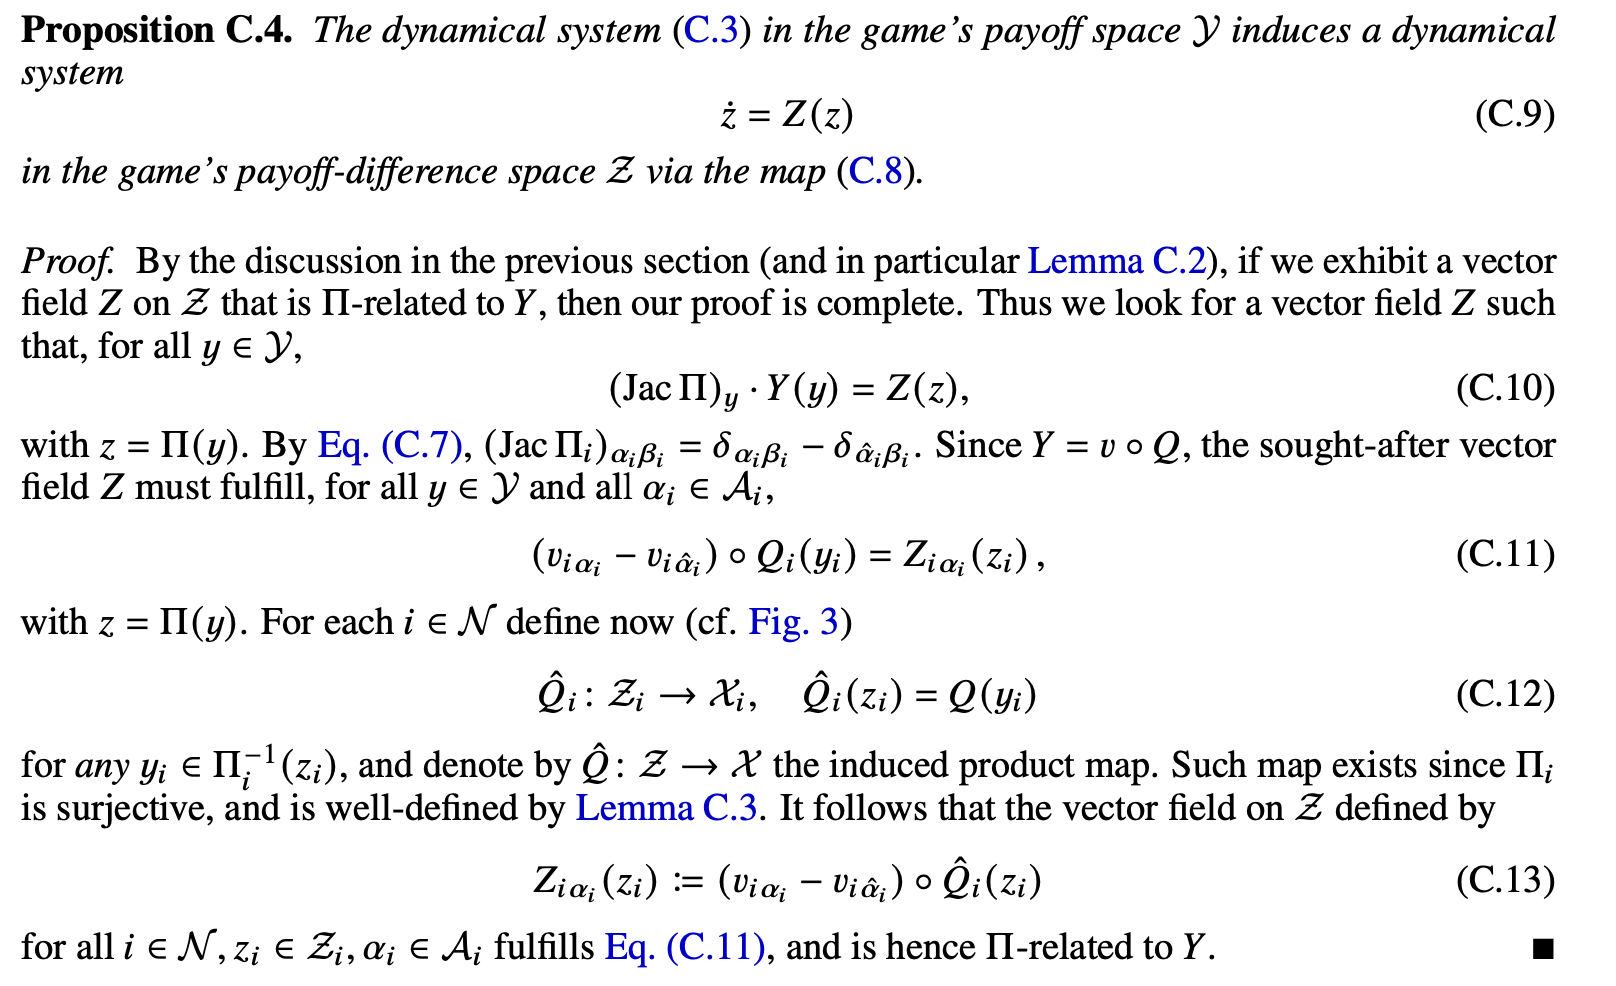

- Denote for simplicity by $V$ and $Q$ the respective objects in $Z$, i.e. $V = V_{.} - V_{.}$ and $Q$ descended to quotient

### FTRL: morally, pull-back and sharp!  $\dot{z} = [Q^{\ast}V]^{\sharp}  (z) = \text{Jac}Q^{-1}(z) \text{Jac}Q(z) \cdot V \circ Q(z)  =  V \circ Q(z)  $


### Pulled FTRL:  $\dot{z} = (Q^{\ast}V)(z) = \text{Jac}Q(z) \cdot V \circ Q(z)   $

## Symplectic corrections

### $\dot{z} = V \circ Q + \lambda [d(V \circ Q)] (V \circ Q)$ converges in spherical; "Euclidean"

### $\dot{z} = V \circ Q + \lambda \big[[d (Q^{\ast}V)](V \circ Q)\big]^{\sharp} $ converges in spherical "Riemannian V1"

### $\dot{z} = Q^{\ast}V(z) + \lambda \big[[d (Q^{\ast}V)](V \circ Q)\big]^{\sharp}$ geometrically not consistent but seems to convege very fast on spherical, slow on potential "Riemannian V2"

## ODE

In [116]:
import random
time = np.linspace(0, 100, 1000)
num_orbits = 4

initial_dual_points = [[random.uniform(-3, 3) for _ in range(4)] for n in range(num_orbits)]
#initial_dual_points = [ [2, 2.5, 2.1, 2.4] ]

In [117]:
initial_dual_points

[[-2.3287203611585134,
  -2.7125217768028236,
  2.7920584191739897,
  -2.3839755616126643],
 [-1.1552690006974058,
  0.6182554827364148,
  -2.865143821619183,
  -2.517772903785006],
 [0.6499216470087115,
  1.1398551289248733,
  2.2765105204008105,
  0.7507774444139592],
 [-0.5187243920159901,
  -0.43996816450736986,
  -2.777827488387616,
  1.26135312611048]]

In [118]:
initial_quot_points = [nfg.Utils.flatten(nfg.Utils.quotient(nfg.Utils.pack( y, skeleton ))) for y in initial_dual_points]
initial_quot_points

[[0.0, -0.38380141564431014, 0.0, -5.176033980786654],
 [0.0, 1.7735244834338206, 0.0, 0.3473709178341773],
 [0.0, 0.4899334819161618, 0.0, -1.5257330759868513],
 [0.0, 0.07875622750862021, 0.0, 4.039180614498096]]

In [119]:
initial_eff_quot_points = [nfg.Utils.flatten( [ z[1:] for z in nfg.Utils.quotient(nfg.Utils.pack( y, skeleton )) ] ) for y in initial_dual_points]
initial_eff_quot_points

[[-0.38380141564431014, -5.176033980786654],
 [1.7735244834338206, 0.3473709178341773],
 [0.4899334819161618, -1.5257330759868513],
 [0.07875622750862021, 4.039180614498096]]

## finite games $\to$ constrained setting & entropic regularizer

In [120]:
def plot_method(ax1, ax2, dual_points, ftrl):
        primal_points = [ftrl.choice(*y) for y in dual_points]
    
        x00, x01, x10, x11 = coords_points(primal_points) # primal coords
        y00, y01, y10, y11 = coords_points(dual_points) # dual coords
    
        ax1.plot(x01[-1], x11[-1], 'ro', label = 'final')
        ax1.plot(x01, x11, 'k')
        ax1.plot(x01[0], x11[0], 'bo', label = 'initial')

        ax2.plot(y01[-1], y11[-1], 'ro', label = 'final')
        ax2.plot(y01, y11, 'k')
        ax2.plot(y01[0], y11[0], 'bo', label = 'initial')
        
        ax1.set_xlim(0,1)
        ax1.set_ylim(0,1)

In [121]:
def plot_Zmethod(ax1, ax2, quot_points, ftrl):
        primal_points = [ftrl.choice(*z) for z in quot_points]
    
        x00, x01, x10, x11 = coords_points(primal_points) # primal coords
        z00, z01, z10, z11 = coords_points(quot_points) # quot coords
    
        ax1.plot(x01[-1], x11[-1], 'ro', label = 'final')
        ax1.plot(x01, x11, 'k')
        ax1.plot(x01[0], x11[0], 'bo', label = 'initial')

        ax2.plot(z01[-1], z11[-1], 'ro', label = 'final')
        ax2.plot(z01, z11, 'k')
        ax2.plot(z01[0], z11[0], 'bo', label = 'initial')
        
        ax1.set_xlim(0,1)
        ax1.set_ylim(0,1)

In [122]:
def plot_effZmethod(ax1, ax2, quot_points, ftrl):
        primal_points = [ftrl.choice(*z) for z in quot_points]
    
        x01, x11 = coords_points(primal_points) # primal coords
        z01, z11 = coords_points(quot_points) # quot coords
    
        ax1.plot(x01[-1], x11[-1], 'ro', label = 'final')
        ax1.plot(x01, x11, 'k')
        ax1.plot(x01[0], x11[0], 'bo', label = 'initial')

        ax2.plot(z01[-1], z11[-1], 'ro', label = 'final')
        ax2.plot(z01, z11, 'k')
        ax2.plot(z01[0], z11[0], 'bo', label = 'initial')
        
        ax1.set_xlim(0,1)
        ax1.set_ylim(0,1)

<lambdifygenerated-66>:2: RuntimeWarning: overflow encountered in scalar power
  return [2*exp(y1_0 + y1_1)/(exp(y1_0) + exp(y1_1))**2 - 2*exp(y0_0 + 2*y0_1)/(exp(y0_0) + exp(y0_1))**3 + 2*exp(2*y0_0 + y0_1)/(exp(y0_0) + exp(y0_1))**3 + 2*exp(y0_0 + y1_0 + y1_1)/((exp(y1_0) + exp(y1_1))**2*exp(y0_0) + (exp(y1_0) + exp(y1_1))**2*exp(y0_1)) - 2*exp(y0_1 + y1_0 + y1_1)/((exp(y1_0) + exp(y1_1))**2*exp(y0_0) + (exp(y1_0) + exp(y1_1))**2*exp(y0_1)), -2*exp(y1_0 + y1_1)/(exp(y1_0) + exp(y1_1))**2 + 2*exp(y0_0 + 2*y0_1)/(exp(y0_0) + exp(y0_1))**3 - 2*exp(2*y0_0 + y0_1)/(exp(y0_0) + exp(y0_1))**3 - 2*exp(y0_0 + y1_0 + y1_1)/((exp(y1_0) + exp(y1_1))**2*exp(y0_0) + (exp(y1_0) + exp(y1_1))**2*exp(y0_1)) + 2*exp(y0_1 + y1_0 + y1_1)/((exp(y1_0) + exp(y1_1))**2*exp(y0_0) + (exp(y1_0) + exp(y1_1))**2*exp(y0_1)), -4*exp(y1_0 + 2*y1_1)/(exp(y1_0) + exp(y1_1))**3 + 4*exp(2*y1_0 + y1_1)/(exp(y1_0) + exp(y1_1))**3 + 4*exp(y0_0 + y0_1 + y1_0)/((exp(y0_0) + exp(y0_1))**2*exp(y1_0) + (exp(y0_0) + exp(y0_1))**

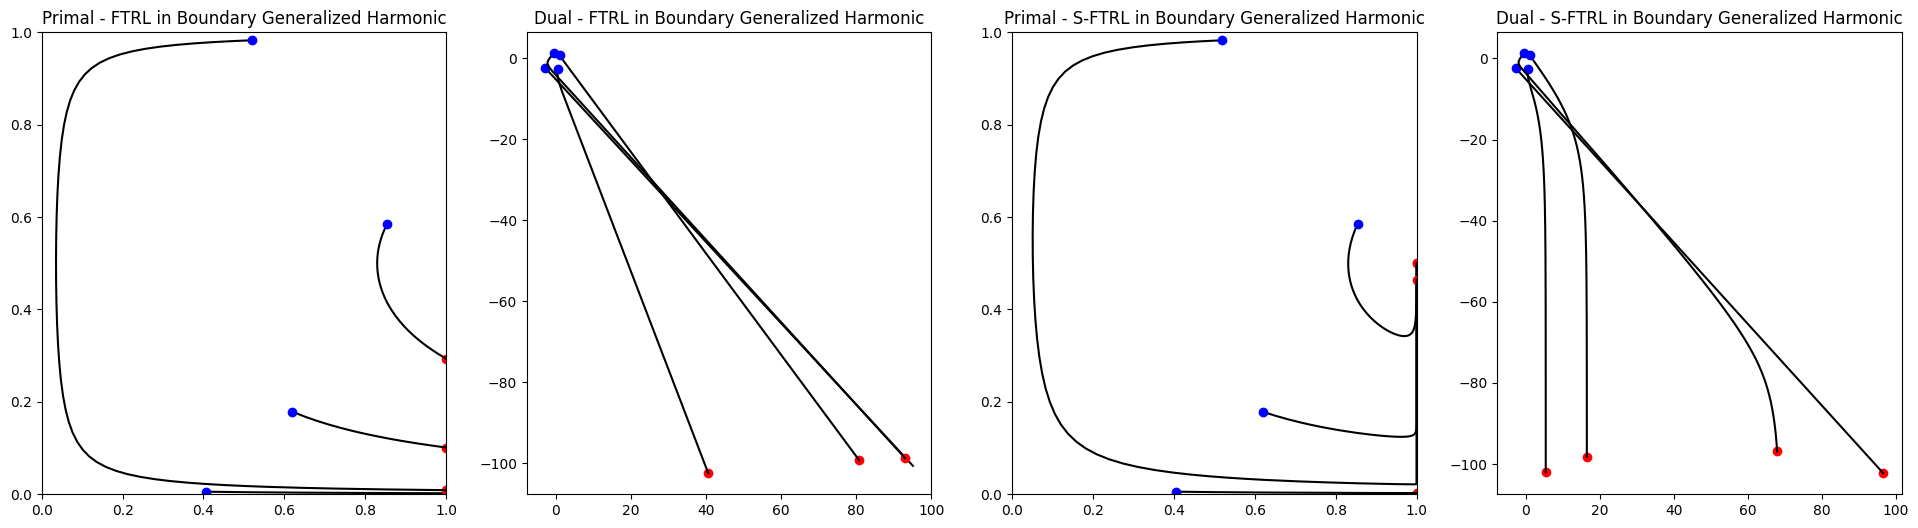

In [123]:
# X and Y

LAM = -0.1

for i, s in enumerate(SFTRL_GAMES):

    fig = plt.figure(figsize = (24,6))
    
    ax1 = fig.add_subplot(1, 4, 1)
    ax2 = fig.add_subplot(1, 4, 2)
    ax3 = fig.add_subplot(1, 4, 3)
    ax4 = fig.add_subplot(1, 4, 4)
    
    for y0 in initial_dual_points:

        dual_points = odeint(s.sftrl_dyn, y0, time, args = (0,))
        plot_method(ax1, ax2, dual_points, s)
        ax1.set_title(f'Primal - FTRL in {s.name}')
        ax2.set_title(f'Dual - FTRL in {s.name}')

        corrected_dual_points = odeint(s.sftrl_dyn, y0, time, args = (LAM,))
        plot_method(ax3, ax4, corrected_dual_points, s)
        ax3.set_title(f'Primal - S-FTRL in {s.name}')
        ax4.set_title(f'Dual - S-FTRL in {s.name}')

    plt.show()
        
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    #plt.legend(loc = 'best')
   


<lambdifygenerated-71>:2: RuntimeWarning: overflow encountered in scalar power
  return [0, -(4*(exp(z0_1) + 1)**2/(cosh(z1_1) + 1) + 4*exp(z0_1))/(exp(z0_1) + 1)**3, 0, 4*((exp(z0_1) + 1)**2/(cosh(z1_1) + 1) + exp(z0_1))*tanh((1/2)*z1_1)/(exp(z0_1) + 1)**2]


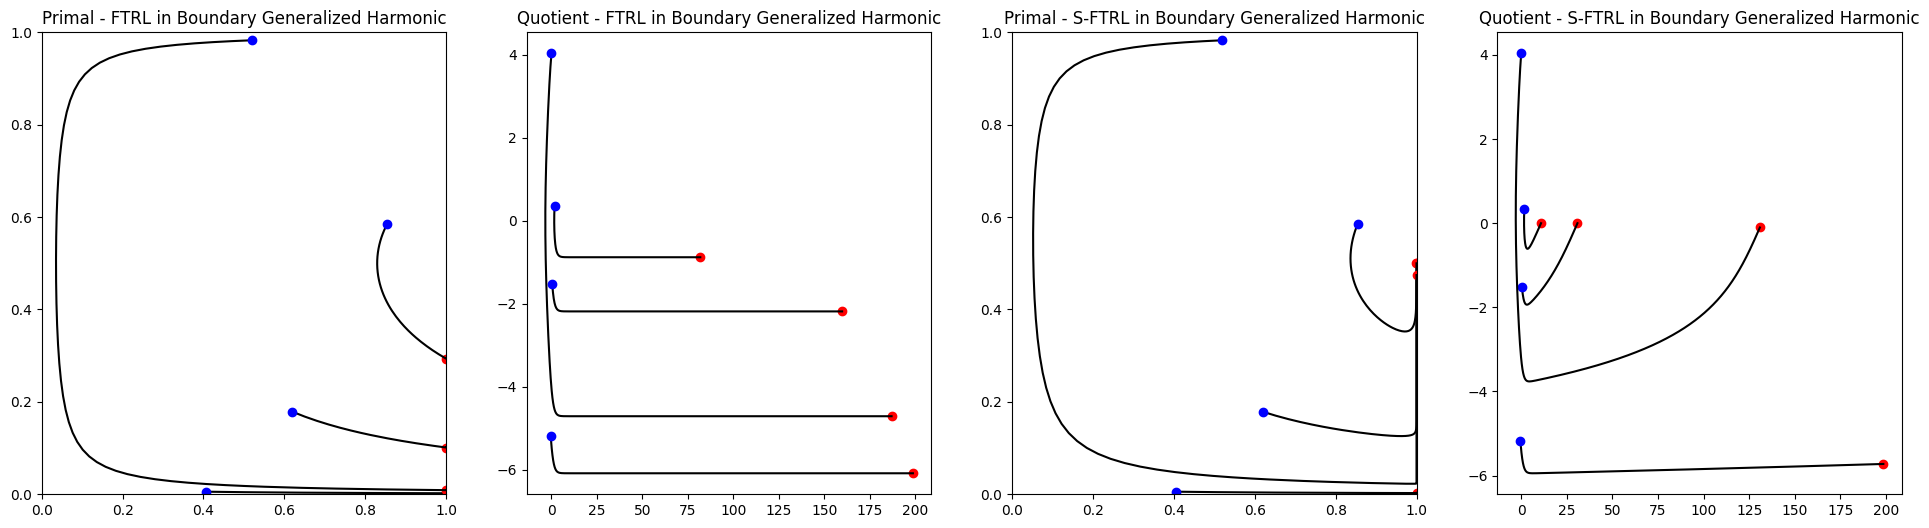

In [124]:
# X and Z, full

LAM = -0.1

for i, s in enumerate(ZSFTRL_GAMES):

    fig = plt.figure(figsize = (24,6))
    
    ax1 = fig.add_subplot(1, 4, 1)
    ax2 = fig.add_subplot(1, 4, 2)
    ax3 = fig.add_subplot(1, 4, 3)
    ax4 = fig.add_subplot(1, 4, 4)
    
    for z0 in initial_quot_points:

        quot_points = odeint(s.sftrl_dyn, z0, time, args = (0,))
        plot_Zmethod(ax1, ax2, quot_points, s)
        ax1.set_title(f'Primal - FTRL in {s.name}')
        ax2.set_title(f'Quotient - FTRL in {s.name}')

        corrected_quot_points = odeint(s.sftrl_dyn, z0, time, args = (LAM,))
        plot_Zmethod(ax3, ax4, corrected_quot_points, s)
        ax3.set_title(f'Primal - S-FTRL in {s.name}')
        ax4.set_title(f'Quotient - S-FTRL in {s.name}')

    plt.show()
        
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    #plt.legend(loc = 'best')
   


In [125]:
eff_ZSFTRL_GAMES

In [126]:
initial_eff_quot_points

[[-0.38380141564431014, -5.176033980786654],
 [1.7735244834338206, 0.3473709178341773],
 [0.4899334819161618, -1.5257330759868513],
 [0.07875622750862021, 4.039180614498096]]

<lambdifygenerated-75>:2: RuntimeWarning: overflow encountered in exp
  return [-6/(exp(z0_1)*cosh(z1_1) + exp(z0_1) + cosh(z1_1) + 1), 6*(exp(3*z1_1) + 3*exp(2*z1_1) + 3*exp(z1_1) + 1)*exp(z0_1 - z1_1)*tanh((1/2)*z1_1)/((exp(z1_1) + 1)*(cosh(z1_1) + 1)*(exp(2*z0_1) + 2*exp(z0_1) + 1))]


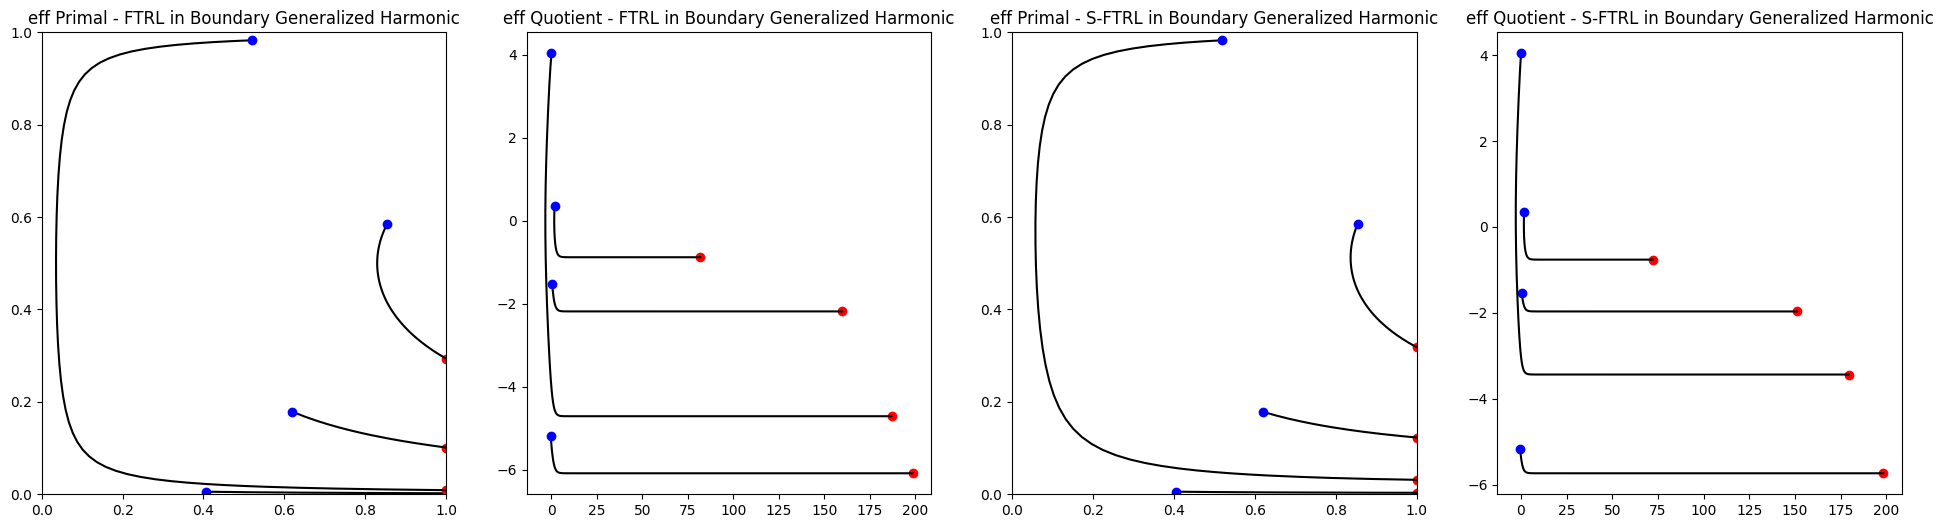

In [127]:
# X and Z effective, ftrl vs symplectic ftrl geometric version

LAM = -0.1

for i, s in enumerate(eff_ZSFTRL_GAMES):

    fig = plt.figure(figsize = (24,6))
    
    ax1 = fig.add_subplot(1, 4, 1)
    ax2 = fig.add_subplot(1, 4, 2)
    ax3 = fig.add_subplot(1, 4, 3)
    ax4 = fig.add_subplot(1, 4, 4)
    
    for z0 in initial_eff_quot_points:

        eff_quot_points = odeint(s.geom_sftrl_dyn, z0, time, args = (0,))
        plot_effZmethod(ax1, ax2, eff_quot_points, s)
        ax1.set_title(f'eff Primal - FTRL in {s.name}')
        ax2.set_title(f'eff Quotient - FTRL in {s.name}')

        corrected_eff_quot_points = odeint(s.geom_sftrl_dyn, z0, time, args = (LAM,))
        plot_effZmethod(ax3, ax4, corrected_eff_quot_points, s)
        ax3.set_title(f'eff Primal - S-FTRL in {s.name}')
        ax4.set_title(f'eff Quotient - S-FTRL in {s.name}')

    plt.show()
        
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    #plt.legend(loc = 'best')
   


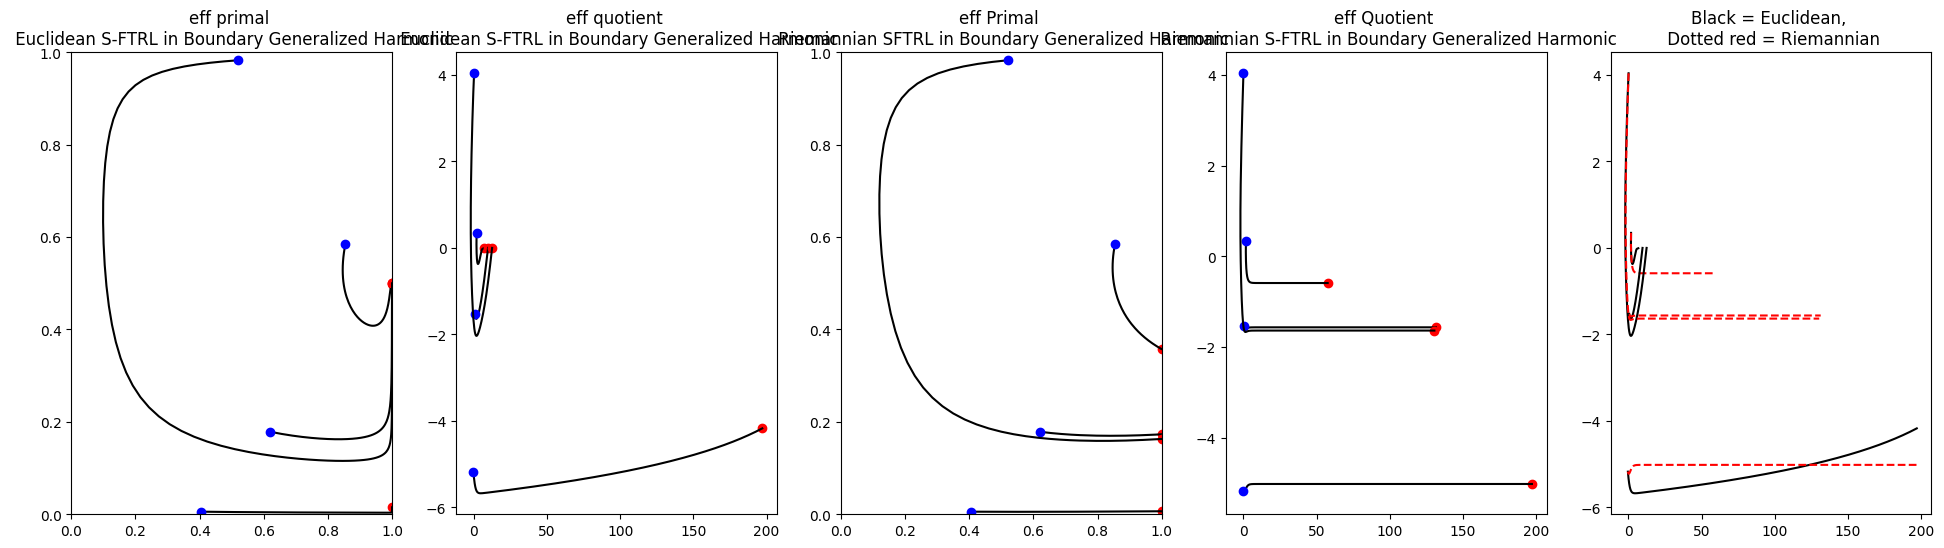

In [128]:
# X and Z effective, symplectic vs geometric symplectic

LAM = -0.3

for i, s in enumerate(eff_ZSFTRL_GAMES):

    fig = plt.figure(figsize = (24,6))
    
    ax1 = fig.add_subplot(1, 5, 1)
    ax2 = fig.add_subplot(1, 5, 2)
    ax3 = fig.add_subplot(1, 5, 3)
    ax4 = fig.add_subplot(1, 5, 4)
    ax5 = fig.add_subplot(1, 5, 5)
    
    for z0 in initial_eff_quot_points:

        eu_eff_quot_points = odeint(s.sftrl_dyn, z0, time, args = (LAM,))
        plot_effZmethod(ax1, ax2, eu_eff_quot_points, s)
        ax1.set_title(f'eff primal \n Euclidean S-FTRL in {s.name}')
        ax2.set_title(f'eff quotient \n Euclidean S-FTRL in {s.name}')

        riem_eff_quot_points = odeint(s.geom_sftrl_dyn, z0, time, args = (LAM,))
        plot_effZmethod(ax3, ax4, riem_eff_quot_points, s)
        ax3.set_title(f'eff Primal \n Riemannian SFTRL in {s.name}')
        ax4.set_title(f'eff Quotient \n Riemannian S-FTRL in {s.name}')
        
        points_diff = eu_eff_quot_points - riem_eff_quot_points
        ax5.plot( *coords_points(eu_eff_quot_points), 'k')
        ax5.plot( *coords_points(riem_eff_quot_points), '--r')
        ax5.set_title('Black = Euclidean, \n Dotted red = Riemannian' )

    

    #plt.legend(loc = 'best')
    plt.show()
        
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    #plt.legend(loc = 'best')
   


<lambdifygenerated-74>:2: RuntimeWarning: overflow encountered in scalar power
  return [-(4*(exp(z0_1) + 1)**2/(cosh(z1_1) + 1) + 4*exp(z0_1))/(exp(z0_1) + 1)**3, 4*((exp(z0_1) + 1)**2/(cosh(z1_1) + 1) + exp(z0_1))*tanh((1/2)*z1_1)/(exp(z0_1) + 1)**2]


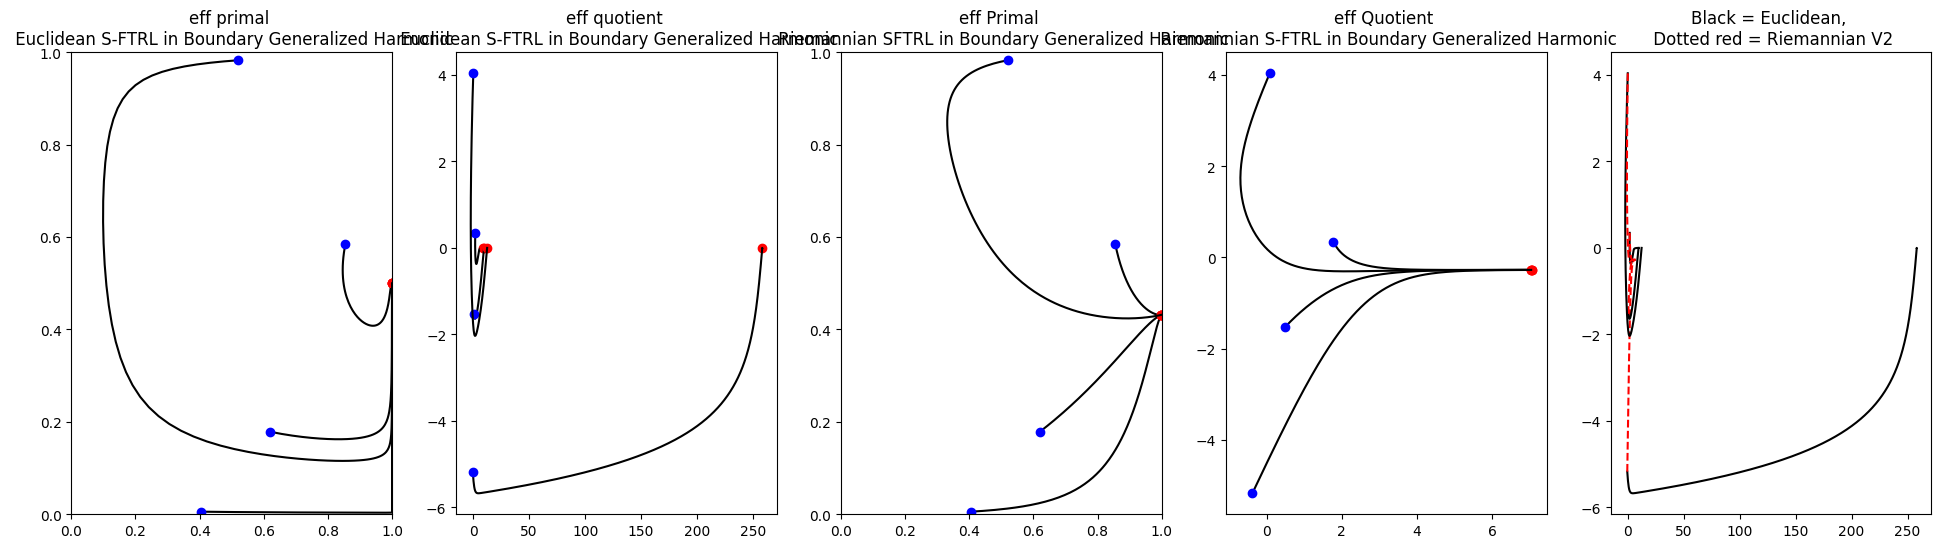

In [129]:
# X and Z effective, symplectic vs geometric symplectic VERSION 2 pulling also first term

time = np.linspace(0, 1000, 10000)

LAM = -0.3

for i, s in enumerate(eff_ZSFTRL_GAMES):

    fig = plt.figure(figsize = (24,6))
    
    ax1 = fig.add_subplot(1, 5, 1)
    ax2 = fig.add_subplot(1, 5, 2)
    ax3 = fig.add_subplot(1, 5, 3)
    ax4 = fig.add_subplot(1, 5, 4)
    ax5 = fig.add_subplot(1, 5, 5)
    
    for z0 in initial_eff_quot_points:

        eu_eff_quot_points = odeint(s.sftrl_dyn, z0, time, args = (LAM,))
        plot_effZmethod(ax1, ax2, eu_eff_quot_points, s)
        ax1.set_title(f'eff primal \n Euclidean S-FTRL in {s.name}')
        ax2.set_title(f'eff quotient \n Euclidean S-FTRL in {s.name}')

        riem_eff_quot_points = odeint(s.geom_sftrl_dyn_2, z0, time, args = (LAM,))
        plot_effZmethod(ax3, ax4, riem_eff_quot_points, s)
        ax3.set_title(f'eff Primal \n Riemannian SFTRL in {s.name}')
        ax4.set_title(f'eff Quotient \n Riemannian S-FTRL in {s.name}')
        
        points_diff = eu_eff_quot_points - riem_eff_quot_points
        ax5.plot( *coords_points(eu_eff_quot_points), 'k')
        ax5.plot( *coords_points(riem_eff_quot_points), '--r')
        ax5.set_title('Black = Euclidean, \n Dotted red = Riemannian V2' )

    

    #plt.legend(loc = 'best')
    plt.show()
        
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    #plt.legend(loc = 'best')
   


<lambdifygenerated-73>:2: RuntimeWarning: overflow encountered in exp
  return [-2*tanh((1/2)*z1_1), -2/(exp(z0_1) + 1)]
<lambdifygenerated-75>:2: RuntimeWarning: invalid value encountered in scalar divide
  return [-6/(exp(z0_1)*cosh(z1_1) + exp(z0_1) + cosh(z1_1) + 1), 6*(exp(3*z1_1) + 3*exp(2*z1_1) + 3*exp(z1_1) + 1)*exp(z0_1 - z1_1)*tanh((1/2)*z1_1)/((exp(z1_1) + 1)*(cosh(z1_1) + 1)*(exp(2*z0_1) + 2*exp(z0_1) + 1))]
/var/folders/nr/_pc5sgrn7833hcljbr9b58680000gn/T/ipykernel_84663/3852804779.py:18: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  riem_1_eff_quot_points = odeint(s.geom_sftrl_dyn, z0, time, args = (LAM,))


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3980767476930D+03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6621911751598D+03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.5565415582287D+03   r2 =                  NaN


<lambdifygenerated-72>:2: RuntimeWarning: overflow encountered in exp
  return [exp(z0_1)/(exp(z0_1) + 1), exp(z1_1)/(exp(z1_1) + 1)]
<lambdifygenerated-72>:2: RuntimeWarning: invalid value encountered in scalar divide
  return [exp(z0_1)/(exp(z0_1) + 1), exp(z1_1)/(exp(z1_1) + 1)]
<lambdifygenerated-72>:2: RuntimeWarning: invalid value encountered in exp
  return [exp(z0_1)/(exp(z0_1) + 1), exp(z1_1)/(exp(z1_1) + 1)]
/usr/local/Cellar/python-matplotlib/3.9.0/libexec/lib/python3.12/site-packages/matplotlib/axes/_base.py:2957: RuntimeWarning: overflow encountered in scalar subtract
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


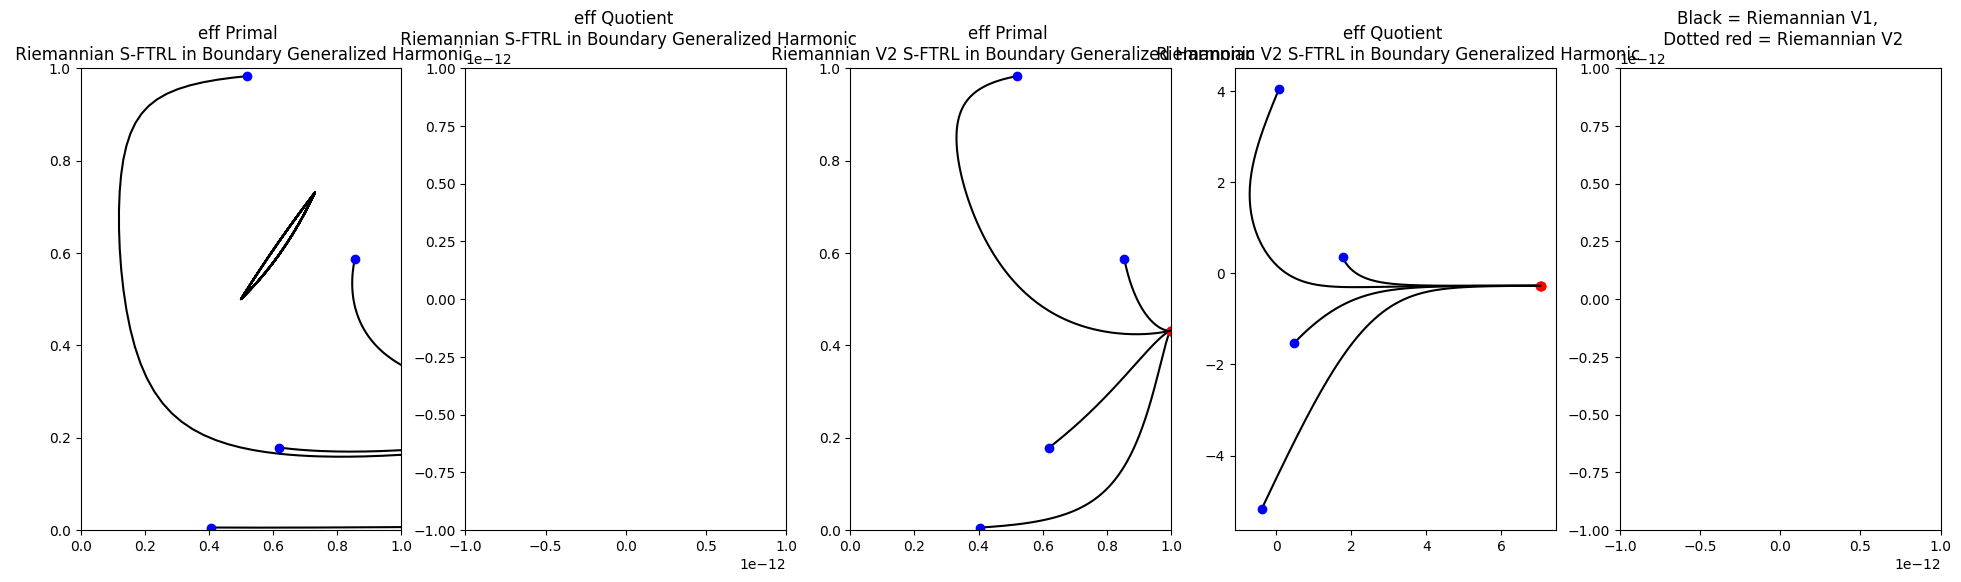

In [130]:
# X and Z effective, geometric symplectic VERSION 1 vs geometric symplectic VERSION 2
time = np.linspace(0, 1000, 10000)

LAM = -0.3

for i, s in enumerate(eff_ZSFTRL_GAMES):

    fig = plt.figure(figsize = (24,6))
    
    ax1 = fig.add_subplot(1, 5, 1)
    ax2 = fig.add_subplot(1, 5, 2)
    ax3 = fig.add_subplot(1, 5, 3)
    ax4 = fig.add_subplot(1, 5, 4)
    ax5 = fig.add_subplot(1, 5, 5)
    
    for z0 in initial_eff_quot_points:

        riem_1_eff_quot_points = odeint(s.geom_sftrl_dyn, z0, time, args = (LAM,))
        plot_effZmethod(ax1, ax2, riem_1_eff_quot_points, s)
        ax1.set_title(f'eff Primal \n Riemannian S-FTRL in {s.name}')
        ax2.set_title(f'eff Quotient \n Riemannian S-FTRL in {s.name}')

        riem_2_eff_quot_points = odeint(s.geom_sftrl_dyn_2, z0, time, args = (LAM,))
        plot_effZmethod(ax3, ax4, riem_2_eff_quot_points, s)
        ax3.set_title(f'eff Primal \n Riemannian V2 S-FTRL in {s.name}')
        ax4.set_title(f'eff Quotient \n Riemannian V2 S-FTRL in {s.name}')
        
        # points_diff = riem_1_eff_quot_points - riem_2_eff_quot_points
        ax5.plot( *coords_points(riem_1_eff_quot_points), 'k')
        ax5.plot( *coords_points(riem_2_eff_quot_points), '--r')
        ax5.set_title('Black = Riemannian V1, \n Dotted red = Riemannian V2' )

    

    #plt.legend(loc = 'best')
    plt.show()
        
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    #plt.legend(loc = 'best')
   


/var/folders/nr/_pc5sgrn7833hcljbr9b58680000gn/T/ipykernel_84663/2298181244.py:18: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  riem_1_eff_quot_points = odeint(s.geom_sftrl_dyn, z0, time, args = (LAM,))


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.4532847474227D+03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3943993808573D+03   r2 =                  NaN


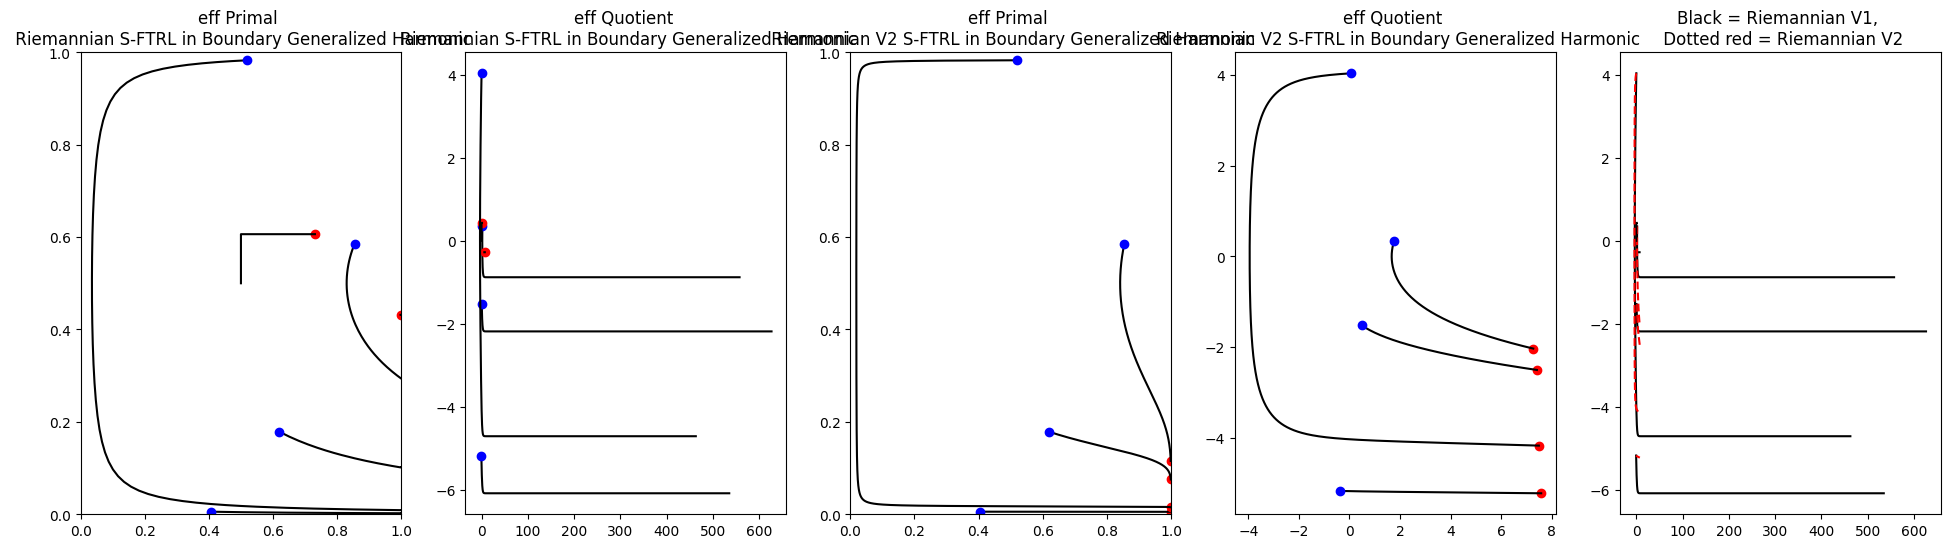

In [131]:
# X and Z effective, geometric symplectic VERSION 1 vs geometric symplectic VERSION 2; lambda = 0 (no sympletic correction)
time = np.linspace(0, 1000, 10000)

LAM = 0

for i, s in enumerate(eff_ZSFTRL_GAMES):

    fig = plt.figure(figsize = (24,6))
    
    ax1 = fig.add_subplot(1, 5, 1)
    ax2 = fig.add_subplot(1, 5, 2)
    ax3 = fig.add_subplot(1, 5, 3)
    ax4 = fig.add_subplot(1, 5, 4)
    ax5 = fig.add_subplot(1, 5, 5)
    
    for z0 in initial_eff_quot_points:

        riem_1_eff_quot_points = odeint(s.geom_sftrl_dyn, z0, time, args = (LAM,))
        plot_effZmethod(ax1, ax2, riem_1_eff_quot_points, s)
        ax1.set_title(f'eff Primal \n Riemannian S-FTRL in {s.name}')
        ax2.set_title(f'eff Quotient \n Riemannian S-FTRL in {s.name}')

        riem_2_eff_quot_points = odeint(s.geom_sftrl_dyn_2, z0, time, args = (LAM,))
        plot_effZmethod(ax3, ax4, riem_2_eff_quot_points, s)
        ax3.set_title(f'eff Primal \n Riemannian V2 S-FTRL in {s.name}')
        ax4.set_title(f'eff Quotient \n Riemannian V2 S-FTRL in {s.name}')
        
        # points_diff = riem_1_eff_quot_points - riem_2_eff_quot_points
        ax5.plot( *coords_points(riem_1_eff_quot_points), 'k')
        ax5.plot( *coords_points(riem_2_eff_quot_points), '--r')
        ax5.set_title('Black = Riemannian V1, \n Dotted red = Riemannian V2' )

    

    #plt.legend(loc = 'best')
    plt.show()
        
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    #plt.legend(loc = 'best')
   


In [132]:
test

In [133]:
TEST = symplecticFTRL.SFTRL(MP.map_payfield, logit.Q, primal_vars, dual_vars, MP.name) 

In [134]:
TEST.sym_symplectic_1form

Matrix([
[ 144*(exp(y0_0) - exp(y0_1))*exp(y0_0 + y0_1 + y1_0 + y1_1)/((exp(y0_0) + exp(y0_1))**3*(exp(y1_0) + exp(y1_1))**2)],
[144*(-exp(y0_0) + exp(y0_1))*exp(y0_0 + y0_1 + y1_0 + y1_1)/((exp(y0_0) + exp(y0_1))**3*(exp(y1_0) + exp(y1_1))**2)],
[ 144*(exp(y1_0) - exp(y1_1))*exp(y0_0 + y0_1 + y1_0 + y1_1)/((exp(y0_0) + exp(y0_1))**2*(exp(y1_0) + exp(y1_1))**3)],
[144*(-exp(y1_0) + exp(y1_1))*exp(y0_0 + y0_1 + y1_0 + y1_1)/((exp(y0_0) + exp(y0_1))**2*(exp(y1_0) + exp(y1_1))**3)]])

In [135]:
TEST.sym_JQ

Matrix([
[exp(y0_0)/(exp(y0_0) + exp(y0_1)) - exp(2*y0_0)/(exp(y0_0) + exp(y0_1))**2,                            -exp(y0_0)*exp(y0_1)/(exp(y0_0) + exp(y0_1))**2,                                                                          0,                                                                          0],
[                           -exp(y0_0)*exp(y0_1)/(exp(y0_0) + exp(y0_1))**2, exp(y0_1)/(exp(y0_0) + exp(y0_1)) - exp(2*y0_1)/(exp(y0_0) + exp(y0_1))**2,                                                                          0,                                                                          0],
[                                                                         0,                                                                          0, exp(y1_0)/(exp(y1_0) + exp(y1_1)) - exp(2*y1_0)/(exp(y1_0) + exp(y1_1))**2,                            -exp(y1_0)*exp(y1_1)/(exp(y1_0) + exp(y1_1))**2],
[                                                                        

## Geometric version must be done in quotient space and in local coordinates to eliminate degeneracy

- $V \circ Q + \lambda [d(V \circ Q)](V \circ Q)$ works in $Y$, but it implies using Euclidean metric in dual space to identify 1-forms and vector fields
- it would be tempting to do $V \circ Q + \lambda \big[[d (Q^{\ast}V)](V \circ Q)\big]^{\sharp}$ to have geometric consistence in $Y$
- howevere these is no natural Riemannian metric in $Y$:
    - in $Y$, $h^{\ast}$ is in general only convex, not strictly convex, so it's hessian is in general not positive definite. In practice, the matrix $\text{Hess}h^{\ast} = \text{Jac}Q$ is **not invertible**, zero determinant (calculation done also on paper), so does not allow to define sharp operator on $Y$. This reflects the degeneracy / redundancy one introduces lifting to dual space
    - one could hope that degenercy can be quotiented away to $Z$ space. In this case though it's not clear which the metric should be, must to it on paper. The naive $\text{Jac} \hat{Q}$ is **not symmetric** if one retains all the coordinates (e.g $(0, z_1, 0, z_2)$ in 2x2 game
    - to get $\text{Jac}\hat{Q}$ both symmetric and positive-definite one must work in local coordinates, i.e. pull-back the vector field $Z$ to the hyperplane; equivalently, work from the very beginnin with effective payoff field. 

In [136]:
SFTRL_GAMES[0].sym_JQ

Matrix([
[exp(y0_0)/(exp(y0_0) + exp(y0_1)) - exp(2*y0_0)/(exp(y0_0) + exp(y0_1))**2,                            -exp(y0_0)*exp(y0_1)/(exp(y0_0) + exp(y0_1))**2,                                                                          0,                                                                          0],
[                           -exp(y0_0)*exp(y0_1)/(exp(y0_0) + exp(y0_1))**2, exp(y0_1)/(exp(y0_0) + exp(y0_1)) - exp(2*y0_1)/(exp(y0_0) + exp(y0_1))**2,                                                                          0,                                                                          0],
[                                                                         0,                                                                          0, exp(y1_0)/(exp(y1_0) + exp(y1_1)) - exp(2*y1_0)/(exp(y1_0) + exp(y1_1))**2,                            -exp(y1_0)*exp(y1_1)/(exp(y1_0) + exp(y1_1))**2],
[                                                                        

In [137]:
SFTRL_GAMES[0].sym_JQ.det()

0

In [138]:
ZSFTRL_GAMES[0].sym_JQ

Matrix([
[0,                              -exp(z0_1)/(exp(z0_1) + 1)**2, 0,                                                          0],
[0, exp(z0_1)/(exp(z0_1) + 1) - exp(2*z0_1)/(exp(z0_1) + 1)**2, 0,                                                          0],
[0,                                                          0, 0,                              -exp(z1_1)/(exp(z1_1) + 1)**2],
[0,                                                          0, 0, exp(z1_1)/(exp(z1_1) + 1) - exp(2*z1_1)/(exp(z1_1) + 1)**2]])

In [139]:
ZSFTRL_GAMES[0].sym_JQ.det()

0

## Positive definite (to check; cf Candogan code)

In [140]:
eff_ZSFTRL_GAMES[0].sym_JQ

Matrix([
[exp(z0_1)/(exp(z0_1) + 1) - exp(2*z0_1)/(exp(z0_1) + 1)**2,                                                          0],
[                                                         0, exp(z1_1)/(exp(z1_1) + 1) - exp(2*z1_1)/(exp(z1_1) + 1)**2]])

In [141]:
eff_ZSFTRL_GAMES[0].sym_JQ.det()

(exp(2*z0_1)*exp(2*z1_1) + exp(2*z0_1)*exp(z1_1) + exp(z0_1)*exp(2*z1_1) + exp(z0_1)*exp(z1_1))/(exp(3*z0_1)*exp(3*z1_1) + 3*exp(3*z0_1)*exp(2*z1_1) + 3*exp(3*z0_1)*exp(z1_1) + exp(3*z0_1) + 3*exp(2*z0_1)*exp(3*z1_1) + 9*exp(2*z0_1)*exp(2*z1_1) + 9*exp(2*z0_1)*exp(z1_1) + 3*exp(2*z0_1) + 3*exp(z0_1)*exp(3*z1_1) + 9*exp(z0_1)*exp(2*z1_1) + 9*exp(z0_1)*exp(z1_1) + 3*exp(z0_1) + exp(3*z1_1) + 3*exp(2*z1_1) + 3*exp(z1_1) + 1)

## ODE

In [142]:
time = np.linspace(0, 100, 10000)

In [143]:
import random

num_orbits = 1

#initial_dual_points = [[random.uniform(-5, 5) for _ in range(4)] for n in range(num_orbits)]
initial_dual_points = [ [2,2.5,2.1,2.4] ]

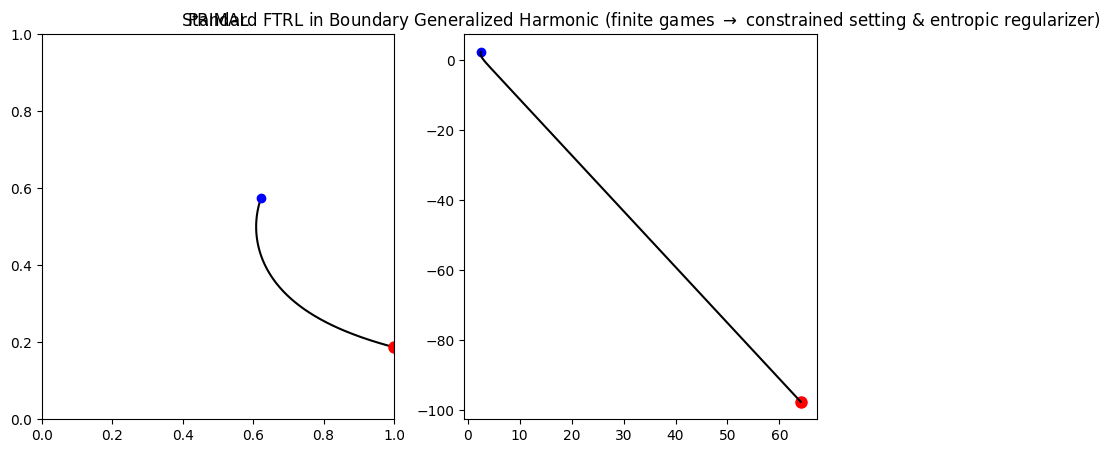

In [144]:
for s in SFTRL_GAMES:
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    for y0 in initial_dual_points:
        dual_points = odeint(s.sftrl_dyn, y0, time, args = (-0.0,))
        y00, y01, y10, y11 = coords_points(dual_points) # dual coords
        ax2.plot(y01[0], y11[0], 'bo', label = 'initial')
        ax2.plot(y01[-1], y11[-1], 'ro', label = 'final', ms = 8)
        ax2.plot(y01, y11, 'k')
        
        primal_points = [s.choice(*y) for y in dual_points]
        x00, x01, x10, x11 = coords_points(primal_points) # primal coords
        ax1.plot(x01, x11, 'k')
        ax1.plot(x01[0], x11[0], 'bo', label = 'initial')
        ax1.plot(x01[-1], x11[-1], 'ro', label = 'final', ms = 8)
    ax1.set_xlim(0,1)
    ax1.set_ylim(0,1)
    ax1.set_title('PRIMAL')
    ax2.set_title('DUAL')
    #plt.legend(loc = 'best')
    plt.title(f'Standard FTRL in {s.name} (finite games $\\to$ constrained setting & entropic regularizer)')
    plt.show()

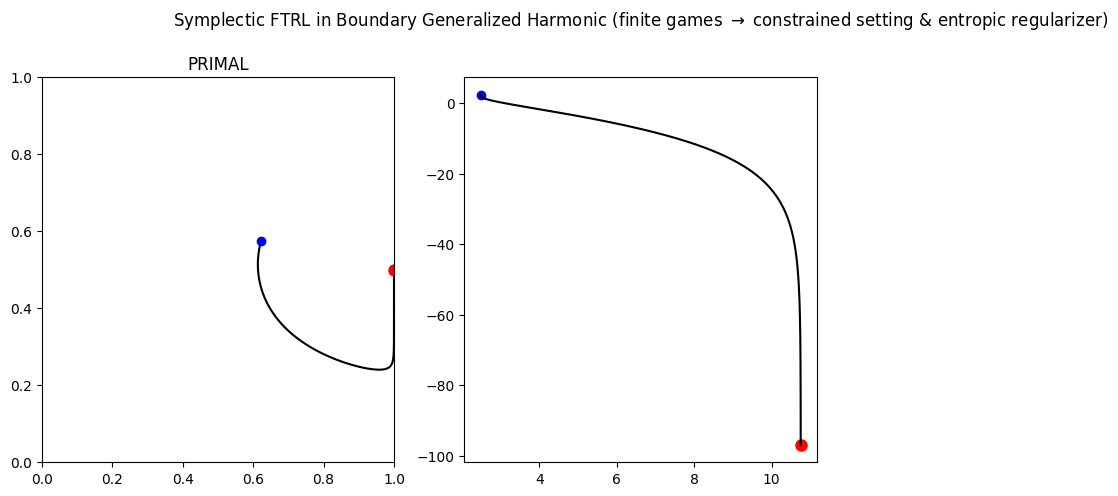

In [145]:
for s in SFTRL_GAMES:
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    for y0 in initial_dual_points:
        dual_points = odeint(s.sftrl_dyn, y0, time, args = (-0.1,))  # <----------- symplectic correction
        y00, y01, y10, y11 = coords_points(dual_points) # dual coords
        ax2.plot(y01[0], y11[0], 'bo', label = 'initial')
        ax2.plot(y01[-1], y11[-1], 'ro', label = 'final', ms = 8)
        ax2.plot(y01, y11, 'k')
        
        primal_points = [s.choice(*y) for y in dual_points]
        x00, x01, x10, x11 = coords_points(primal_points) # primal coords
        ax1.plot(x01, x11, 'k')
        ax1.plot(x01[0], x11[0], 'bo', label = 'initial')
        ax1.plot(x01[-1], x11[-1], 'ro', label = 'final', ms = 8)
        
    ax1.set_xlim(0,1)
    ax1.set_ylim(0,1)
    ax1.set_title('PRIMAL')
    ax2.set_title('DUAL')
    plt.title(f'Symplectic FTRL in {s.name} (finite games $\\to$ constrained setting & entropic regularizer)\n\n')
    plt.show()